In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt

In [2]:
# get train data (use for train & test )
path = lambda number:r"C:\Users\14020\Desktop\NCBDC 2019\Data\NormaliezdData\NormlizedTrainData"+'\\'+str(number)+".csv"
traindflist=[]
DFSIZE=158
for i in range(DFSIZE):
    df=pd.read_csv( path(i) ).iloc[:,1:]
    traindflist.append(df)

In [3]:
# get test data
path = lambda number:r"C:\Users\14020\Desktop\NCBDC 2019\Data\NormaliezdData\NormilizedTestData"+'\\'+str(number)+".csv"
testdflist=[]
DFSIZE=52
for i in range(DFSIZE):
    df=pd.read_csv( path(i) ).iloc[:,1:]
    testdflist.append(df)

# get data prepared

In [4]:
inputfeature=['total_voltage', 'total_current', 'soc', 'temp_max', 'temp_min',
       'motor_voltage', 'motor_current', 'total_P', 'motor_P',
       'tempMAXMINdiff', 'SOCgap']
outputfeature=['milediff']
TimeStep=24

# 带TimeStep的LSTM

In [5]:
RNNX=[]
RNNY=[]
for df in traindflist:
    X=df.loc[:,inputfeature].to_numpy()
    y=df.loc[:,outputfeature].to_numpy()
    lens=len(df)
    for index in range(TimeStep,lens):
        RNNX.append(X[index-TimeStep:index])
        RNNY.append(y[index-TimeStep:index].sum())
RNNX=np.array(RNNX)
RNNY=np.array(RNNY)
RNNX.shape,RNNY.shape

((240319, 24, 11), (240319,))

## 数据分为测试集和训练集（可没有此步 ，因为我们有选择测试数据集）

In [6]:
from sklearn.model_selection import train_test_split #这里是引用了交叉验证
X_train,X_test, y_train, y_test = train_test_split(RNNX,RNNY,test_size = 0.1,random_state=100)

In [7]:
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)

(216287, 24, 11) (216287,) (24032, 24, 11) (24032,)


In [8]:
X_train=RNNX
y_train=RNNY

## RNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop
import matplotlib.pyplot as plt
import math
import tensorflow as tf

Using TensorFlow backend.


### lr_reduce 设置损失不减则降低学习率
### checkPoint设置保存模型

In [10]:
PathName=r"C:\Users\14020\Desktop\NCBDC 2019\model\RNN"
filepath=PathName+"\\3rd_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

D:\ANACONDA\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


### 设置模型输入

In [11]:
BUFFER_SIZE=100
BATCH_SIZE=25
train_data_single = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

##  设置模型结构

In [12]:
input_shape=X_train.shape[-2:]

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=input_shape))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
#single_step_model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.009) , metrics = ['mean_squared_error'])

In [13]:
EPOCHS=30
EVALUATION_INTERVAL=500
time_start=time.time()
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50,callbacks = [checkpoint , lr_reduce])
time_end=time.time()

Train for 500 steps, validate for 50 steps
Epoch 1/30
493/500 [============================>.] - ETA: 0s - loss: 0.2351
Epoch 00001: val_loss improved from -inf to 0.86092, saving model to C:\Users\14020\Desktop\NCBDC 2019\model\RNN\3rd_weights.hdf5
500/500 [==============================] - 11s 22ms/step - loss: 0.2347 - val_loss: 0.8609
Epoch 2/30
494/500 [============================>.] - ETA: 0s - loss: 0.1947
Epoch 00002: val_loss did not improve from 0.86092
500/500 [==============================] - 4s 8ms/step - loss: 0.1939 - val_loss: 0.4334
Epoch 3/30
495/500 [============================>.] - ETA: 0s - loss: 0.1797
Epoch 00003: val_loss did not improve from 0.86092
500/500 [==============================] - 4s 8ms/step - loss: 0.1794 - val_loss: 0.3846
Epoch 4/30
492/500 [============================>.] - ETA: 0s - loss: 0.1617
Epoch 00004: val_loss did not improve from 0.86092

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
500/500 [======

Epoch 30/30
499/500 [============================>.] - ETA: 0s - loss: 0.3690
Epoch 00030: val_loss did not improve from 0.86092

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000142800998e-27.
500/500 [==============================] - 4s 8ms/step - loss: 0.3691 - val_loss: 0.2744


In [14]:
print('totally cost',time_end-time_start)

totally cost 131.5915162563324


## 画出模型loss曲线 查看收敛效果

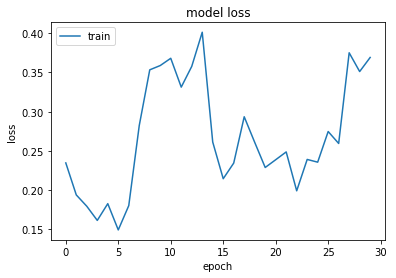

In [15]:
import matplotlib.pyplot as plt
plt.plot(single_step_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## (如果有)对上面分出来的测试数据测试（非我们小组定义的测试数据集）

In [16]:
pred = single_step_model.predict(X_test)
pred,pred.shape,X_test.shape

(array([[ 1.6662506 ],
        [-0.09523639],
        [ 2.3163042 ],
        ...,
        [ 1.6203413 ],
        [ 0.00898113],
        [ 2.597105  ]], dtype=float32), (24032, 1), (24032, 24, 11))

## 对指定测试集的数据查看

In [17]:
number=0
df=testdflist[number]
TestX=[]
TestY=[]
X=df.loc[:,inputfeature].to_numpy()
y=df.loc[:,outputfeature].to_numpy()
lens=len(df)
for index in range(TimeStep,lens):
    if(int(index % TimeStep)==0):
        TestX.append(X[index-TimeStep:index])
        TestY.append(y[index-TimeStep:index].sum())
TestX=np.array(TestX)
TestY=np.array(TestY)
pred = single_step_model.predict(TestX)
pred = pred.cumsum()
print("测试集",number,"的预测结果是：",pred[-1],"真实结果是",df.iloc[-1].milegap)
diff=pred[-1]-df.iloc[-1].milegap
print("相差：",diff)

测试集 0 的预测结果是： 143.78136 真实结果是 123.90000000000146
相差： 19.881356811521982


In [18]:
difflist=[]
for number,df in enumerate(testdflist):
    TestX=[]
    TestY=[]
    X=df.loc[:,inputfeature].to_numpy()
    y=df.loc[:,outputfeature].to_numpy()
    lens=len(df)
    for index in range(TimeStep,lens):
        if(int(index % TimeStep)==0):
            TestX.append(X[index-TimeStep:index])
            TestY.append(y[index-TimeStep:index])
    TestX=np.array(TestX)
    TestY=np.array(TestY)
    pred = single_step_model.predict(TestX)
    pred = pred.cumsum()
    print("测试集",number,"的预测结果是：",pred[-1],"真实结果是",df.iloc[-1].milegap)
    diff=pred[-1]-df.iloc[-1].milegap
    difflist.append(diff/df.iloc[-1].milegap)

测试集 0 的预测结果是： 143.78136 真实结果是 123.90000000000146
测试集 1 的预测结果是： 115.157555 真实结果是 106.79999999999563
测试集 2 的预测结果是： 124.001465 真实结果是 106.90000000000146
测试集 3 的预测结果是： 67.86873 真实结果是 54.59999999999855
测试集 4 的预测结果是： 117.615074 真实结果是 102.20000000000437
测试集 5 的预测结果是： 114.45572 真实结果是 116.5
测试集 6 的预测结果是： 104.63107 真实结果是 105.39999999999418
测试集 7 的预测结果是： 118.05609 真实结果是 115.69999999999708
测试集 8 的预测结果是： 20.232481 真实结果是 18.599999999998552
测试集 9 的预测结果是： 96.02374 真实结果是 101.19999999999708
测试集 10 的预测结果是： 114.26906 真实结果是 98.0
测试集 11 的预测结果是： 129.7114 真实结果是 122.09999999999854
测试集 12 的预测结果是： 124.837166 真实结果是 116.29999999999563
测试集 13 的预测结果是： 131.64833 真实结果是 115.89999999999418
测试集 14 的预测结果是： 130.87833 真实结果是 122.79999999999563
测试集 15 的预测结果是： 129.34517 真实结果是 114.29999999999563
测试集 16 的预测结果是： 141.97038 真实结果是 121.0
测试集 17 的预测结果是： 103.69202 真实结果是 126.89999999999418
测试集 18 的预测结果是： 119.39316 真实结果是 112.40000000000146
测试集 19 的预测结果是： 110.2518 真实结果是 112.60000000000582
测试集 20 的预测结果是： 79.127785 真实结果是 77.69999999999709
测试

In [19]:
PathName=r"C:\Users\14020\Desktop\NCBDC 2019\model\RNN"

In [20]:
MSE=(sum(np.array(difflist)**2)/52)**(1/2)
print("MSE:",MSE)

MSE: 0.19519778682338101


In [21]:
def save(filename, inputfeature,outputfeature,TimeStep,MSE,model):
    fh = open(filename, 'w', encoding='utf-8')
    fh.write("inputfeature:")
    for string in inputfeature:
        fh.write(string)
    fh.write('\r')
    fh.write("outputfeature:")
    for string in outputfeature:
        fh.write(string)
    fh.write('\r')
    fh.write("TimeStep:")
    fh.write(str(TimeStep))
    fh.write('\r')
    fh.write("MSE:")
    fh.write(str(MSE))
    fh.write('\r')
    fh.write("model:")
    fh.write(model)
    fh.write('\r')
    fh.close()
save(PathName+"\\3rdDemo.txt",inputfeature,outputfeature,TimeStep,MSE,"LSTM(32),Dense(1),optimizer=tf.keras.optimizers.RMSprop(), loss='mae'")
#single_step_model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001) , metrics = ['mean_squared_error'])")

Useless code